In [101]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

Problem 1: Understanding the Data

In [102]:
# Marketing campaigns by going through the documentation.
45211

45211

Problem 2: Read in the Data

In [103]:
df = pd.read_csv('/content/sample_data/bank-additional-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Problem 3: Understanding the Features

In [104]:
null_columns = df.columns[df.isna().any()].tolist()
null_columns
# There are no columns with missing values

[]

Problem 4: Understanding the Task

In [105]:
df.info()

# Objective of the task is to identify customers that may be intereseted in subscribing to service or not.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Problem 5: Engineering Features

In [106]:
# data (as pandas dataframes)
X = df.drop('y', axis=1)
y = df.y

# Encode and Transform
le = LabelEncoder()
y = le.fit_transform(y)

# Categorical and Numerical Columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(categorical_columns)
print(numerical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


Problem 6: Train/Test Split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Problem 7: A Baseline Model

In [108]:
dummy_clf = DummyClassifier().fit(X_train, y_train)
baseline_score = dummy_clf.score(X_test, y_test)
print(baseline_score)

0.8865015780529255


Problem 8: A Simple Model

In [109]:
logreg = LogisticRegression(solver='lbfgs', max_iter=10000).fit(X_train[numerical_columns], y_train)
print(logreg)

LogisticRegression(max_iter=10000)


Problem 9: Score the Model

In [110]:
preds = logreg.predict(X_test[numerical_columns])
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy: .2f}')

Accuracy:  0.91


Problem 10: Model Comparisons

In [111]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

# Define the models and hyperparameters
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

results = []
cms = []
roc_aucs = []
fprs = []
tprs =[]

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)

    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)

    # Train time
    train_time = (time.time() - start_time)

    # Get the best estimator
    best_model = grid_search.best_estimator_

    # Train Accuracy
    y_train_pred = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Test Accuracy
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Append the results
    results.append([name, train_time, train_accuracy, test_accuracy])

    # Confusion Matrix
    cms.append(confusion_matrix(y_test, best_model.predict(X_test)))

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(auc(fpr, tpr))

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy',
                                            'Test Accuracy'])
results_df.set_index('Model', inplace=True)

# Save to JSON (for submission if needed)
results_df.to_json('/content/sample_data/model_results.json')

# Read file
df1 = pd.read_json(r'/content/sample_data/model_results.json')
df1

,Train Time,Train Accuracy,Test Accuracy
knn,22.949778,0.924219,0.904467
logisticregression,8.279189,0.911836,0.911143
decisiontreeclassifier,5.489983,0.917420,0.915028


Visualizations

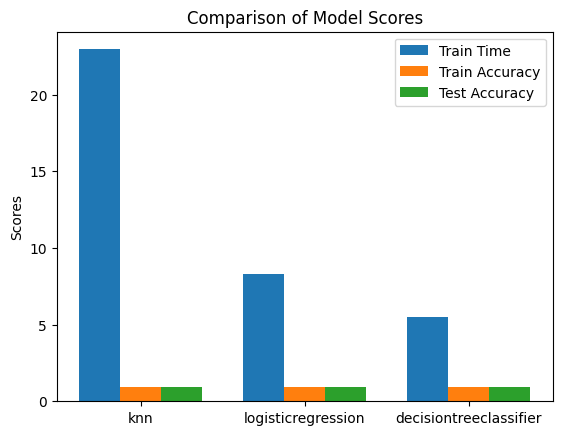

In [112]:
# Comparing Model Scores
results_df = results_df.reset_index()
models = results_df['Model']
train_times = results_df['Train Time']
train_accuracies = results_df['Train Accuracy']
test_accuracies = results_df['Test Accuracy']

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_times, width, label='Train Time')
rects2 = ax.bar(x, train_accuracies, width, label='Train Accuracy')
rects3 = ax.bar(x + width, test_accuracies, width, label='Test Accuracy')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Scores')
ax.legend()
plt.show()

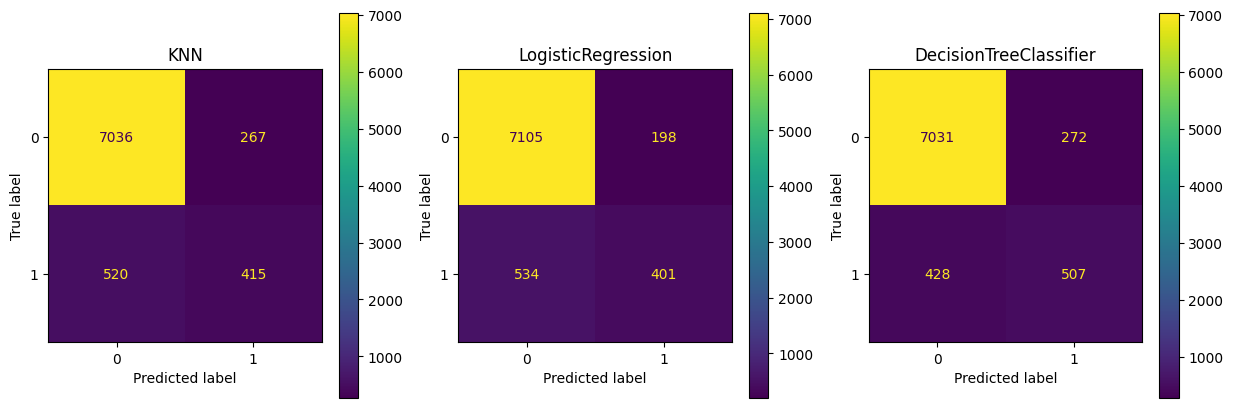

In [121]:
# Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ConfusionMatrixDisplay(cms[0]).plot(ax=ax[0])
ax[0].set_title('KNN')
ConfusionMatrixDisplay(cms[1]).plot(ax=ax[1])
ax[1].set_title('LogisticRegression')
ConfusionMatrixDisplay(cms[2]).plot(ax=ax[2])
ax[2].set_title('DecisionTreeClassifier')
plt.show()

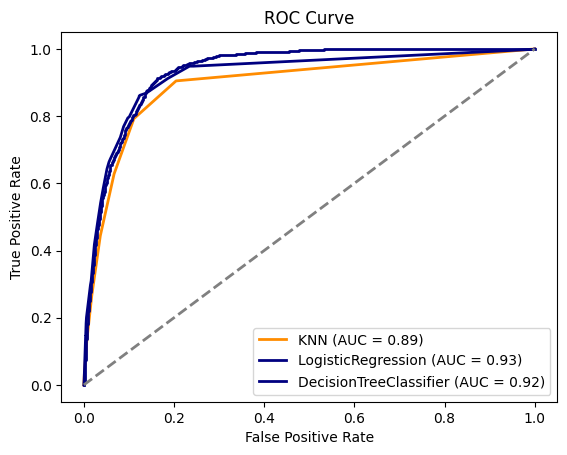

In [114]:
# ROC Curve
plt.figure()
plt.plot(fprs[0], tprs[0], color='darkorange', lw=2, label='KNN (AUC = %0.2f)' % roc_aucs[0])
plt.plot(fprs[1], tprs[1], color='navy', lw=2, label='LogisticRegression (AUC = %0.2f)' % roc_aucs[1])
plt.plot(fprs[2], tprs[2], color='navy', lw=2, label='DecisionTreeClassifier (AUC = %0.2f)' % roc_aucs[2])
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Problem 11: Improving the Model

In [115]:
# Additionally evaluate 'Train Score', 'Test Score', 'Average Fit time', 'F1 Score'

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

# Define the models and hyperparameters
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)

    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)

    # Train time
    train_time = (time.time() - start_time)

    # Mean Fit Time
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])

    # Get the best estimator
    best_model = grid_search.best_estimator_

    # Train Accuracy
    y_train_pred = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Test Accuracy
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Train Score
    train_score = best_model.score(X_train, y_train)

    # Test Score
    test_score = best_model.score(X_test, y_test)

    # F1 Score
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Append the results
    results.append([name, train_time, train_accuracy, test_accuracy, train_score, test_score, fit_time, f1])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy',
                                            'Test Accuracy', 'Train Score', 'Test Score',
                                            'Average Fit time', 'F1 Score'])
results_df.set_index('Model', inplace=True)

# Save to JSON (for submission if needed)
results_df.to_json('/content/sample_data/model_results.json')

# Read file
df2 = pd.read_json(r'/content/sample_data/model_results.json')
df2

,Train Time,Train Accuracy,Test Accuracy,Train Score,Test Score,Average Fit time,F1 Score
knn,27.010374,0.924219,0.904467,0.924219,0.904467,9.003458,0.897807
logisticregression,6.628786,0.911836,0.911143,0.911836,0.911143,2.209596,0.902411
decisiontreeclassifier,6.281785,0.917420,0.915028,0.917420,0.915028,2.093929,0.911610


Since evaluation of SVM is taking super long time for huge dataset so let's take small data set to compare results.

In [116]:
df = pd.read_csv('/content/sample_data/bank-additional.csv', sep = ';')
df.shape

(4119, 21)

In [117]:
# data (as pandas dataframes)
X = df.drop('y', axis=1)
y = df.y

# Encode and Transform
le = LabelEncoder()
y = le.fit_transform(y)

# Categorical and Numerical Columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

# Define the models and hyperparameters
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)

    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)

    # Train time
    train_time = (time.time() - start_time)

    # Get the best estimator
    best_model = grid_search.best_estimator_

    # Train Accuracy
    y_train_pred = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Append the results
    results.append([name, train_time, train_accuracy, test_accuracy])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy',
                                            'Test Accuracy'])
results_df.set_index('Model', inplace=True)

# Save to JSON (for submission if needed)
results_df.to_json('/content/sample_data/model_results.json')

# Read file
df3 = pd.read_json(r'/content/sample_data/model_results.json')
df3

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


,Train Time,Train Accuracy,Test Accuracy
knn,1.220916,0.942033,0.915028
logisticregression,0.973337,0.920486,0.915028
svc,6.303530,0.914112,0.915028
decisiontreeclassifier,0.886040,0.930804,0.915028


More feature engineering and exploration. For example, should we keep the gender feature? Why or why not?

In [118]:
# There is no feature like Gender in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

Number of customers who subscribed services or not based on given data

In [119]:
len(df.query('y == "no"'))/df.shape[0] * 100

89.0507404709881

In [120]:
len(df.query('y == "yes"'))/df.shape[0] * 100

10.949259529011895

Summary:

1. Objective of the task is to identify customers that may be intereseted in subscribing to service or not.
2. Based on the analysis of dataset, it would help to gather more data for the customers who subscribed to the service as around 10% only subscribed to service out of total dataset.
3. Also dataset seems to imbalanced.
4. Comparing model using large dataset resulted in utilizing Logistic Regression model for this task.
5. Comparing model using small dataset to include SVM also resulted in utilizing Logistic Regression model for this task.
